In [1]:
import numpy as np
import pandas as pd
import math
import feyn
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as pl

This version of feyn and the QLattice is available for academic, personal, and non-commercial use. By using the community version of this software you agree to the terms and conditions which can be found at `https://abzu.ai/privacy`.


In [2]:
def td2hr(temp, tempd):
    """
    Returns the relative humidity from the temperature and the dew point
    Formula from:
    https://www.aprweather.com/pages/calc.htm
    Both float values or numpy matrices can be passed as input
    and get as output
    Args:
        temp (float, numpy array): The temperature in Celsius
        tempd (float, numpy array): The dew point in Celsius
    Returns:
        float, numpy array: The relative humidity in %
    """
    es = 10**(7.5*tempd/(237.7+tempd))
    e = 10**(7.5*temp/(237.7+temp))

    return 100*(es/e)

In [3]:
df = pd.read_csv('./pon_ml_test.csv')
df.head()

,datetime,obs_ptype,obs_source,xcoord,ycoord,zcoord,tair,tdew
0,2010-01-01 15:30:00,sn,xom,430465.00,4694361.00,1998.545300,-2.083397,-6.269243
1,2010-01-02 18:00:00,ra,xom,463111.00,4621813.00,153.655910,6.430273,4.411478
2,2010-01-02 22:18:00,ra,isd,422807.07,4572137.65,1.024822,9.736761,5.130121
3,2010-01-02 22:30:00,ra,isd,422807.07,4572137.65,1.024822,9.736761,5.130121
4,2010-01-03 08:00:00,ra,xom,298146.00,4545108.00,30.411295,1.492985,0.929277


In [4]:
df.columns[df.isna().any().values].to_list()

[]

In [5]:
df['ros'] = df['obs_ptype'].replace({'sn':1, 'sl':1, 'rn':0, 'ra': 0})

In [6]:
df_mod = df.drop(['obs_source', 'obs_ptype', 'datetime'], axis=1)

In [7]:
len(df_mod)

57175

In [8]:
df_mod = df_mod.drop(df_mod[df_mod.tair < -7.5 ].index)
df_mod = df_mod.drop(df_mod[df_mod.tair > 7.5 ].index)

In [9]:
len(df_mod)

14008

In [10]:
df_mod['ros'].unique()

array([1, 0])

In [11]:
train, test = train_test_split(df_mod, test_size=0.4, random_state=42, stratify=df_mod['ros'])
valid, hold = train_test_split(test, test_size=0.4, stratify=test['ros'], random_state=42)


In [12]:
df_mod.head()

,xcoord,ycoord,zcoord,tair,tdew,ros
0,430465.0,4694361.0,1998.545300,-2.083397,-6.269243,1
1,463111.0,4621813.0,153.655910,6.430273,4.411478,0
4,298146.0,4545108.0,30.411295,1.492985,0.929277,0
5,334136.0,4676720.0,623.122700,4.763386,2.421687,0
10,436325.0,4629120.0,542.273800,3.196497,2.790720,0


In [13]:
ql = feyn.connect_qlattice()

Deprecation: The connect_qlattice() is deprecated. Use the `feyn.QLattice()` constructor instead.


In [24]:
confusion_matrix = {"tp": 0, "tn":0, "fp": 0, "fn": 0}
for index, row in train.iterrows():
    rh = td2hr(row['tair'], row['tdew'])
    ks = 1-(1/(1+math.exp(2.7*row['tair'] - 0.2* rh)))
    if ks >=0.66:
        if row['ros'] == 1:
            confusion_matrix["tp"]+=1
        else:
            confusion_matrix["fp"]+=1
    else:
        if row['ros'] == 1:
            confusion_matrix["fn"]+=1
        else:
            confusion_matrix["tn"]+=1
print(confusion_matrix)

{'tp': 21, 'tn': 5289, 'fp': 1079, 'fn': 2015}


In [15]:
models = ql.auto_run(train, 'ros', kind='classification', n_epochs=10)

<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="216.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 861 216.0" width="861" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="155.0" width="591" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="481" y="50.0"><title>ros
logistic:
w=2.6107
bias=-1.1712</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="526.0" y="71.5">ros</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="569" y="59.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="483" y="59.0">out</text><line stroke="#1E1E1E" x1="451" x2="481" y1="67.5" y2="67.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="361" y="50.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="71.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="59.0">1</text><line stroke="#1E1E1E" x1="331" x2="361" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="331" x2="361" y1="97.5" y2="76.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="20.0"><title>tanh</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="41.5">tanh</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="29.0">2</text><line stroke="#1E1E1E" x1="211" x2="241" y1="67.5" y2="37.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="50.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="71.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="59.0">3</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="97.5" y2="76.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>tdew
linear:
scale=0.066279
scale offset=1.826703
w=-5.861593
bias=0.0864</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="41.5">tdew</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="29.0">4</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="29.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="80.0"><title>tair
linear:
scale=0.133504
scale offset=3.601424
w=-1.552948
bias=-0.7050</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="101.5">tair</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="89.0">5</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="89.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="241" y="80.0"><title>tair
linear:
scale=0.133504
scale offset=3.601424
w=-1.103405
bias=-0.3525</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:no
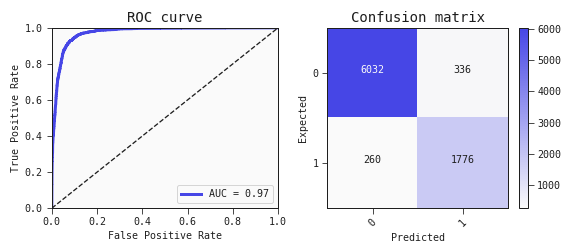
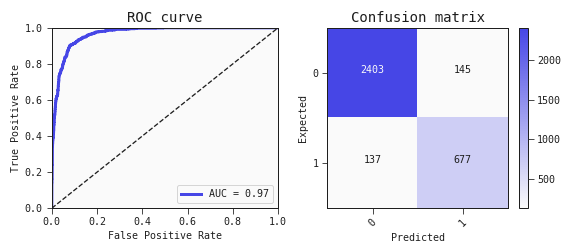

In [16]:
models[0].plot(train, valid)

In [17]:
models[3].params

[{'w': -1.956811243851272, 'bias': 0.7689531732089208},
 {},
 {'scale': 0.13350388304248162,
  'scale_offset': 3.601423762770192,
  'w': 2.1317864128921538,
  'bias': 1.4292393943093922,
  'detect_scale': 0},
 {},
 {},
 {'scale': 0.06627928854084149,
  'scale_offset': 1.8267027141326924,
  'w': -5.240924077804982,
  'bias': -0.3952027045942074,
  'detect_scale': 0},
 {'scale': 8.028420608955703e-06,
  'scale_offset': 401763.0651393363,
  'w': 0.7126126313866571,
  'bias': -2.2445629485351386,
  'detect_scale': 0}]

In [18]:
models[3].sympify()

logreg(-0.556912*tair - 1.95681*tanh((0.239329 - 0.347365*tdew)*(5.72115e-6*xcoord - 4.54311)) - 0.0221227)

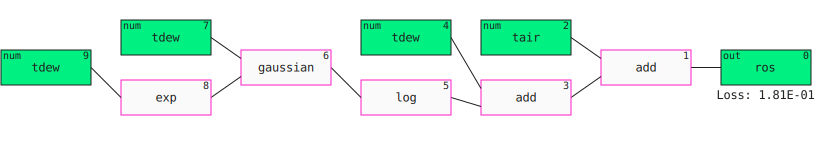

In [19]:
models[7]

In [20]:
models[7].sympify()

logreg(-0.500136*tair - 0.094837*tdew - 0.47499*log(exp(-5.22772*(0.196624*tdew - 1)**2 - 2.76815*exp(-0.352741*tdew))) - 2.96794)

In [21]:
dd = models[7].sympify()
